<a href="https://colab.research.google.com/github/Kande13/SDC_ML_U/blob/main/03_hugging_face_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px">

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1 style = "text-align:center" > Introduction à Hugging Face </h1></center>
<center><h3 style = "text-align:center" > Modèle BERT et Fine Tuning </h3></center>
<hr style="border-width:2px;border-color:#75DFC1">

> Maintenant que le rappel sur PyTorch a été fait, adaptons et entraînons un modèle d'Hugging Face pour la classification de sentiments. Mais, avant ça, un petit rappel sur les transformers et une présentation du modèle BERT et CamemBERT.


## Rappel sur les Transformers

> Les premiers Transformers ont été développés par Google et publiés dans le célèbre papier de recherche [Attention is all you need](https://arxiv.org/abs/1706.03762).
>
> Comme pour les RNN, le Transformer est adapté au traitement de données séquentielles. Avant la sortie du Transformer, l'état de l'art de beaucoup de tâches comme la traduction était détenu par des RNNs avec des mécanismes d'attention.
>
> La force des RNNs est qu'ils fonctionnent de manière similaire aux MLPs mais sont capables de comprendre l'importance de l'ordre des mots dans une phrase. En effet, les mots sont encodés un par un à travers le réseau en laissant une trace dans les états cachés du réseau. Ainsi, l'ordre des mots va grandement impacter l'encodage d'une phrase.
>
> Quant au Transformer, il n'utilise que des `dense` layers et des mécanismes d'attention pour encoder/décoder une séquence, ce qui rend les calculs beaucoup plus parallélisable comparés au RNN. Il encode tous les mots simultanément en parallèle.
>
> Voici le schéma de l'architecture entière telle que présentée dans le papier ***Attention is all you need*** :
>
> <br>
>
> <img src = "https://assets-datascientest.s3-eu-west-1.amazonaws.com/train/Transformer_full.png" style = "width:800px">
>
> Comme le mécanismes d'attention n'est pas capable naïvement de comprendre l'ordre des mots dans la phrase, les auteurs du papier *Attention is all you need* ont proposé une solution pour encoder la position d'un mot dans une phrase directement dans son vecteur d'Embedding.


## Structure des Transformers

> Selon l'utilisation, il n'est pas toujours nécessaire d'utiliser un encodeur ou un décodeur. En effet, dans le cas de la classification de texte, il n'est pas nécessaire d'avoir un décodeur. Un simple encodeur avec une tête de classification est suffisant. Alors que dans des tâches nécessitant une génération, il sera nécessaire d'avoir au moins un décodeur.
>
>
> Dans les modèles avec uniquement un **encodeur**, comme les modèles BERT, RoBERTa, CammemBERT, FlauBERT, ils pourront être utilisés pour des tâches comme la classification de texte (analyse de sentiment, détection de langue, type de documents...), des tâches de classification de tokens (NER, POS Tagging...) et bien d'autres.
>
>
> Dans les modèles avec uniquement un **décodeur**, comme le GPT, ils sont utilisés initialement dans la génération de texte, mais, adaptable à n'importe quelle problématique de NLP. Il sera cependant nécessaire d'adapter la sortie du modèle pour son entraînement ou son utilisation.
>
>
> Enfin, des modèles avec un **encodeur** et un **décodeur**, comme le T5, sont généralement utilisés dans le cas où il est nécessaire d'encoder une donnée d'entrée pour générer une sortie (par exemple, encoder dans le langage source pour le générer dans le langage cible).



<hr style="border-width:2px;border-color:#75DFC1">
<center><h3 style = "text-align:center" > Modèle BERT </h3></center>
<hr style="border-width:2px;border-color:#75DFC1">

> Le modèle BERT (Bidirectional Encoder Representations from Transformers) est un modèle de traitement du langage naturel (NLP) développé par Google. Il s'agit d'un modèle avec uniquement un encodeur sur le transformer.
>
> Le modèle BERT est d'abord pré-entraîné sur de vastes quantités de données textuelles, telles que des livres, des articles et des pages Web. Au cours de ce pré-entraînement, BERT apprend au travers de problématique non-supervisées (prédire des mots masqués...) à capturer plus facilement la sémantique du langage (sens des mots, contexte, subtilité), mais apporte également au modèle une connaissance générale.
>
> Après l'entraînement, le modèle BERT peut être utilisé dans une grande variété de tâches de NLP, peut être réentraîner sur des tâches spécifiques, telles que la classification de texte, la détection d'entités nommées, la compréhension des intentions des utilisateurs, etc. (sur toutes problématiques où le modèle n'a pas besoin d'un décodeur).
>
> Détaillons maintenant un peu plus la phase de pré-entraînement et de Fine Tuning du modèle.
>
><img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/notebooks/hugging_face_bert.jpg">
>
><center><b>Source : </b> Provenant du <a href=https://arxiv.org/abs/1810.04805>papier de recherche BERT</a></center>

## Pré-entraînement

> En effet, les modèles Transformers, de manière générale, ont d'excellentes propriétés de "transfer learning", et sans cette étape, les modèles ne surpasseraient guère les approches plus traditionnelles comme les BoW, TFIDF... Comme dans l'entraînement des Word Embeddings, il est généralement préférable en NLP de pré-entraîner les modèles sur une tâche nécessitant du texte, et par conséquent sur un entraînement non supervisé.
>
> <div class="alert alert-info"><i class="fa fa-info-circle"></i> &emsp;
Pré-entraîner le modèle sur des tâches supervisées (sentiment analysis...) risque de complètement biaiser les embeddings, et le modèle risque de ne capturer que les informations en rapport avec la tâche (par exemple, le sentiment des mots, mais pas le sens en lui-même).</div>
>
>
> Ce pré-entraînement permet au modèle de capturer la sémantique du langage (sens des mots, subtilité du langage, contexte, sarcasme et bien plus), mais aussi un transfert de connaissances du domaine des documents sur lequel le modèle est entraîné.
>
> Dans cette phase, le modèle est entraîné sur un jeu de données [BooksCorpus](https://huggingface.co/datasets/bookcorpus) (800M mots) contenant environ 11k livres et [English Wikipedia](https://huggingface.co/datasets/wikipedia/viewer/20220301.en/train) (2,500M mots), en ignorant les listes, tableaux et en-têtes.
>
>  Il utilise deux tâches de pré-entraînement principales: "Masked Language Modeling" (MLM) et "Next Sentence Prediction" (NSP).
>
>
>
> * **Next Sentence Prediction** (NSP) : Dans cette tâche, le modèle reçoit deux phrases et doit prédire si la deuxième phrase est la suite logique de la première. La tâche aide le modèle BERT à comprendre la relation entre les phrases, ce qui est une information structurelle plus large que celle que l'on peut obtenir en regardant simplement les mots individuels. D'après le papier de recherche, cela a permis des améliorations pour des tâches comme le "Question Answering" (QA) ou le "Natural Language Inference" (NLI), puisqu'ils nécessitent de bien comprendre les relations entre plusieurs phrases.
>
>
> <img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/notebooks/hugging_face_bert_snp.png">
>
>
> <div class="alert alert-info">
><i class="fa fa-info-circle"></i> &emsp;
Plus précisément, lors du choix des phrases A et B, 50 % du temps, B est la phrase qui suit A, et sinon, c'est une phrase aléatoire prise dans le corpus.
></div>
>
>
>
> * **Masked Language Modeling** (MLM) : Dans cette tâche, environ **15% des mots** de la phrase sont masqués (remplacé par un token "[mask]"), et le modèle est alors entraîné à prédire ces mots masqués en se basant sur le contexte de la phrase. Le MLM aide le modèle à comprendre le contexte dans lequel un mot est utilisé. En d'autres termes, il aide le modèle à apprendre que le sens d'un mot peut changer en fonction des mots qui l'entourent. Par exemple, le mot "canard" peut désigner un animal ou une action d'évitement, selon le contexte.
>
>
> <img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/notebooks/hugging_face_bert_mask.png">
>
>
> <div class="alert alert-info">
><i class="fa fa-info-circle"></i> &emsp;
Les concepteurs de BERT ont décidé d'introduire un certain niveau de bruit dans le processus pour aider le modèle à mieux généraliser. Plus précisément, pour chaque mot qui est sélectionné pour être masqué :<ul>
    <li>80% du temps, le mot est remplacé par le token masque "[MASK]".</li>
    <li>10% du temps, le mot est remplacé par un autre mot aléatoire.</li>
    <li>10% du temps, le mot n'est pas changé du tout.</li>
></ul>
></div>
>
>
> En choisissant ces deux tâches de pré-entraînement, les concepteurs de BERT visent à créer un modèle qui comprend à la fois le contexte des mots au niveau de la phrase et la structure des textes à un niveau plus large. De plus, ces deux tâches peuvent être effectuées en utilisant des données non étiquetées à grande échelle, ce qui est un avantage important pour le pré-entraînement de modèles de langage qui doivent comprendre une grande variété de textes.



## Fine Tuning

>
>
> Une fois le modèle BERT pré-entraîné, il suffit en suite d'adapter la structure à la tâche souhaitée puis de réentraîner le modèle. Par exemple, dans le cas de la classification de documents, une couche "Dense" est appliquée sur l'embedding du premier token ([CLS]) :
>
>
> <img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/notebooks/hugging_face_bert_classification.png">
>
> <div class="alert alert-info"><i class="fa fa-info-circle"></i> &emsp;
Il est intéressant de noter que tous les paramètres sont entraînés avec un learning rate très bas lors de la phase de fine tuning du modèle.  </div>
>
>
> Mais, il est tout à fait possible d'adapter la structure sur d'autres tâches comme la sentence pair classification (similairité entre deux phrases par exemple), la reconnaissance d'entitée nommée (NER), la détéction de la nature grammaticale (POS Tagging), question answering (trouver les tokens dans le contexte qui réponde à la question) et bien d'autres applications.
>
>
> <img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/notebooks/hugging_face_bert_tasks.png">


## Variante du modèle BERT

> Depuis l'adoption du modèle BERT, de nombreuses variantes et améliorations ont été introduites. Quelques exemples :
>
>
>* [RoBERTa](https://arxiv.org/abs/1907.11692) (Robustly Optimized BERT Approach) : une version de BERT optimisée par Facebook, avec plus de paramètres et des séquences plus longues lors d'entraînement, beaucoup plus de données (BookCorpus/wikipedia anglais (16GB), CC-News (76GB), OpenWebText (38GB) et Stories (31GB)), sans la tâche NSP, préentraînement uniqument avec un masquage dynamique.
>
> <div class="alert alert-info"><i class="fa fa-info-circle"></i> &emsp;
L'implémentation du BERT original utilise un masque dit statique, en effet, leur masquage a été fait lors du prétraitement des données, ce qui a donné un seul masque statique par donnée (la donnée aura toujours le même masquage). Pour avoir plus de variété, ils ont fait passer 10 fois chaque texte afin que chaque séquence soit masquée de 10 manières différentes.
Alors que dans le cas masquage dynamique, c'est appliqué au moment d'alimenter le modèle. </div>
>
>
> * [DistilBERT](https://arxiv.org/abs/1910.01108): une version réduite de BERT introduite par Hugging Face qui est environ 40% plus petite et 60% plus rapide, tout en conservant 95% des performances de BERT. Lors du pré-entraînement, le modèle DistilBERT recherche à copier la prédiction du modèle BERT sur la tâche de prédiction des mots . Pour cela, les auteurs utilisent trois fonctions de pertes :
>
>> * Une fonction de **perte de distallation**, qui recherchera à faire que le modèle prédise la même distribution de probabilité que le modèle BERT.
>>
>> $$ L{ce} = \sum_i^C t_i * \log(s_i)$$ avec C le nombre de classe, $t_i$ la probabilité du modèle bert et $s_i$ la probabilité du distilBERT.
>>
>> <div class="alert alert-info"><i class="fa fa-info-circle"></i> &emsp;
Pour éviter d'avoir une distribution de probabilité trop inégale (trop forte probabilité sur la classe cible), ils appliquent une "softmax-temperature"  $p_i = \frac{exp(z_i/T)}{\sum_jexp(z_j/T)}$ sur les deux modèles. </div>
>>
>> * Une fonction de perte **cross-entropy** entre la **vraie target** et la **prédiction du distilBERT** ($L{mlm}$) sur la tâche de "masked language modeling" (MLM) $ L{mlm} = -\log(s)$ avec $s$ la probabilité du modèle distilBERT sur la classe cible.
>>
>>
>> * Une fonction de perte de **[cosine embedding](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html)** entre les embeddings du distilBERT et du modèle BERT pour aligner les directions des embeddings entre les deux modèles. Ici, la définition pour chaque état de la séquence : $L{cos} = 1 - \cos(S_{BERT}, S_{distilBERT})$
>>
>>
>> <img src='https://assets-datascientest.s3-eu-west-1.amazonaws.com/notebooks/hugging_face_distilbert.png'>
>>
>>
>><center><i><b>Figure :</b> Présentation de la fonction de perte sur le 3ème token</i></center>
>
> * [CamemBERT](https://arxiv.org/abs/1911.03894): c'est une variante de RoBERTa adaptée à la langue française.

<hr style="border-width:2px;border-color:#75DFC1">
<center><h2 style = "text-align:center" > Application </h2></center>
<hr style="border-width:2px;border-color:#75DFC1">

> La sélection d'un modèle pourra se faire essentiellement sur deux grands critères :
>
> * le **temps d'inférence**: souvent relié au nombre de paramètres du modèle.
>
>
> * la **performance du modèle** sur sa tâche de base ou sur des benchmarks: une référence en anglais peut être [GLUE](https://gluebenchmark.com/leaderboard), ou en français [FLUE](http://fluebenchmark.com/).
>
>
> Il est aussi possible de trouver des spaces sur Hugging Face qui contiennent des leaderboards:
> * **Leaderboard pour du text embedding**: https://huggingface.co/spaces/mteb/leaderboard
>
> * **Leaderboard pour des LLMs**: https://huggingface.co/spaces/lmarena-ai/chatbot-arena-leaderboard
>
>
> Ici, nous allons nous orienter vers le modèle FlauBERT, qui est une variante du RoBERTa adaptée à la langue française, sorti un peu après le modèle CamemBERT. Il existe deux variantes "Base" ou "Large" possédant globalement plus de paramètres que le CamemBERT.
>
>
><img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/notebooks/hugging_face_bert_flaubert_datasets.png">
>
>
> Ce modèle propose généralement des résultats un peu meilleurs que le modèle CamemBERT, surtout dans sa forme "Large".

## Chargement des données et préparation

* Charger dans un dataframe **`df`** le jeu de données https://assets-datascientest.s3.eu-west-1.amazonaws.com/datasets/nlp/insurrance-cleaned.csv.


* Faire un bref audit dessus.

In [ ]:
!pip install -q -U acceleration
!pip install -q sacremoses
!pip install -q evaluator
#restart the kernel
import os
os.kill(os.getpid(), 9)

In [ ]:
import pandas as pd
df = pd.read_csv('https://assets-datascientest.s3.eu-west-1.amazonaws.com/datasets/nlp/insurrance-cleaned.csv', index_col=0)
df = df.sample(1000)
df.head()


,Commentaire,day,Mois,year,Note,Assureur,Produit,month,date,Langue,...,chain_capslock,exclamations,chain_exclamation,interogation,chain_interogation,etc,nb_caracter,nb_words,nb_sentences,cleaned
37923,Satisfaction mitigé. Sur le papier c'est bien,20,juin,2013,1.5,DIRECT-ASSURANCE,Assurance-Auto,6,2013-06-20 18:48:00,__label__fr,...,0,0,0,0,0,0,45,7,1,satisfaction mitiger . papier bien
20877,Je suis vraiment satisfaite. Merci de tant vei...,9,août,2021,3.5,SOGESSUR,Autres-Produits,8,2021-08-09,__label__fr,...,0,0,0,0,0,0,159,22,2,vraiment satisfaire . veiller client particuli...
56364,Tarif tres conpétitif aucun probléme pour assu...,12,février,2009,5.0,MACIF,Assurance-Auto,2,2009-02-12 20:15:00,__label__fr,...,0,0,0,0,0,0,269,47,0,tarif . conpétitif aucun probléme assurer type...
35806,"Plus d'1 mois de traitement du dossier, interl...",16,avril,2015,2.0,APRIL,Assurance-Habitation,4,2015-04-16 08:13:00,__label__fr,...,0,0,0,0,0,1,121,20,0,d'1 mois traitement dossier interlocuteur comm...
30399,Viré de la Matmut après deux sinistres respons...,22,novembre,2020,2.0,MATMUT,Assurance-Habitation,11,2020-11-22,__label__fr,...,0,0,0,0,0,0,178,31,3,virer matmut sinistre responsable 35 an . \n m...


> Dans cette implémentation, nous allons rechercher à prédire si le commentaire est positif ou non. On considérera qu'un commentaire est négatif si sa note est inférieure ou égale à 2.5.

* Ajouter une colonne sous le nom **`target`** qui indique si le commentaire est négatif (0) ou positif (1).


* Afficher la répartition.

<AxesSubplot: ylabel='count'>

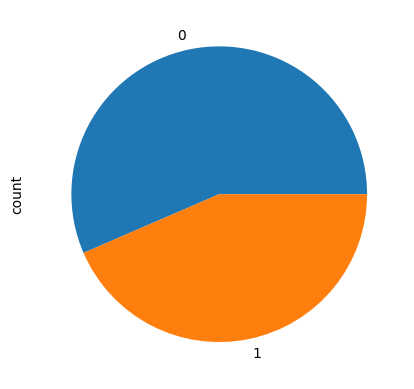

In [ ]:
df["target"] =  df['Note'].apply(lambda x : 1 if x>2.5 else 0)
df.target.value_counts().plot.pie()

* Exécuter la cellule suivante pour séparer les données.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['Commentaire'].values,
    df['target'].values,
    test_size=0.2,
    random_state=123,
)

* Charger le tokenizer "flaubert/flaubert_base_cased" sous le nom **`tokenizer`**.


* Appliquer la méthode **`tokenize`** au texte "Les étudiants sèchent quand il fait beau".

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("flaubert/flaubert_base_cased")

## Equivalent
# from transformers import FlaubertModel, FlaubertTokenizer
# tokenizer = FlaubertTokenizer.from_pretrained("flaubert/flaubert_base_cased")

tokenizer.tokenize("Les étudiants sèchent quand il fait beau")

['Les</w>',
 'étudiants</w>',
 'sè',
 'chent</w>',
 'quand</w>',
 'il</w>',
 'fait</w>',
 'beau</w>']

> Il est intéressant de remarquer dans le résultat plus haut que le tokenizer n'est pas à l'échelle du mot, mais à une échelle plus petite. En effet, ce tokenizer trouve le bon compromis entre dimension et sens. Un tokenizer à l'échelle du mot risque d'exploser en dimension à cause de la variété des formes qu'un mot peut avoir (par exemple, "manger", "mangé", "mangeant"). Alors qu'un tokenizer à l'échelle du caractère cause des longueurs de séquence trop grande et qu'une simple lettre peut changer le sens d'un mot (par exemple, "hat" et "hate").
>
> Les modèles RoBertA ou FlauBERT et bien d'autres utilisent l'approche de tokenisation "[Byte Pair Encoding](https://arxiv.org/abs/1508.07909)" (BPE). Ils résolvent ces problèmes en tokenisant à un niveau sublexical (partie d'un mot). L'idée est d'identifier les paires de bytes (ou caractères) les plus fréquentes dans le corpus de texte et de les traiter comme une seule unité. Par exemple, le mot "chat" pourrait être divisé en "c", "h", "a", "t" au début, mais si "ch" est une paire fréquente, elle serait traitée comme une seule unité "ch" à l'avenir.
>
>
> Voici un exemple de comment BPE fonctionne en pratique :
>
>0. Compter l'occurence de chaque mot du vocabulaire provenant du jeu d'entraînement.
>
>
>```python
>("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
>```
>
>
>1. Initialisation : Chaque mot est d'abord divisé en caractères individuels
>```
>("h" "u" "g", 10), ("p" "u" "g", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "u" "g" "s", 5)
>```
>
>> On petit ici initialiser notre vocabulaire de base à:
>>
>>```python
>>voc_base = ["b", "g", "h", "n", "p", "s", "u"]
>>```
>
>
>2. Fréquence des paires : On identifie la paire de caractères consécutifs la plus fréquente dans le corpus. Par exemple, ici, la paire "ug" apparaît 20 fois.
>```
("h" "ug", 10), ("p" "ug", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "ug" "s", 5)
>```
>
>3. On fusionne "u" et "g", puis on met à jour le vocabulaire de base
>
>```python
>voc_base = ["b", "g", "h", "n", "p", "s", "u", "ug"]
>```
>
>4. Répétez les étapes 2 et 3 autant de fois que vous le souhaitez, en créant de plus en plus de symboles composés.
>
>
>Au fil du temps, cela permet de créer un vocabulaire de sous-mots, où chaque "mot" est soit un caractère unique, soit une chaîne de caractères qui apparaissent fréquemment ensemble. Ce vocabulaire peut ensuite être utilisé pour tokeniser de nouveaux textes.

## Définition du générateur


> Maintenant que le tokenizer a été chargé, préparons les données pour le modèle.
>
>
> Comme présenté dans l'exercice précédent, il existe plusieurs approches pour préparer les données et les séparer en lot. Si il y'a un besoin de flexibilité, l'approche par générateur personnalisé est préférable. Il sera en suite nécessaire de le combiner avec un `DataLoader` pour créer des lots de données.
>
>```python
>import torch
>from torch.utils.data import DataLoader
>
>class NewsGroupsDataset(torch.utils.data.Dataset):
>     def __init__(self, X, y, device="cpu", max_length=256):
>         self.X = X
>         self.y = y
>         self.max_length = max_length
>         self.device = device
>
>     def __getitem__(self, idx):
>         text = self.X[idx]
>         # Transformation des données
>         encoding = tokenizer(text,
>                             truncation=True,        # Couper le texte jusqu'au max_length
>                             padding='max_length',   # Faire du padding jusqu'au max_length
>                             max_length=self.max_length,         # Taille maximale des tokens
>                             return_tensors="pt")    # Format renvoyé après tokenization ('pt' == pytorch)
>         
>
>         return {'input_ids':encoding['input_ids'][0].to(self.device),
>                 'token_type_ids':encoding['token_type_ids'][0].to(self.device),
>                 'attention_mask':encoding['attention_mask'][0].to(self.device) ,
>                 'labels':torch.tensor(self.y[idx]).to(self.device)}
>
>
>     def __len__(self):
>         return len(self.X)
>
>
>train_set = NewsGroupsDataset(X_train, y_train)
>train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
>```
>
><br></br>
>*  Ou, si la donnée est déjà chargée :
>
>```python
># Transformer tous les textes en format d'entrée du modèle.
> encoded_data_train = tokenizer.batch_encode_plus(
    X_train, # Liste de texte
    add_special_tokens=True, # Ajouter un token spécial lors de la tokenization [CLS]...
    return_attention_mask=True, # Retourne pour chaque token si c'est un mot ou un token padding
    truncation=True, # Couper les textes jusqu'au max_length
    padding='max_length',   # Faire du padding jusqu'a la max_length
    max_length=max_length, # Taille maximale des tokens
    return_tensors="pt", # Format renvoyé après tokenization ('pt' == tenseur)
)
>train_set = TensorDataset(encoded_data_train["input_ids"], encoded_data_train["attention_mask"], torch.tensor(y_train))
># Regrouper sous forme de lot de données.
>train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
>```
>
> Vous trouver l'implémentation par `TensorDataset` au travers de ce colab : https://colab.research.google.com/drive/1hR8Og0umoC9O6d7NATg-iwowNbHJHSCH?usp=sharing


* Définir un générateur personnalisé adapté à votre problématique.


* Définir une instance du générateur sous le nom **`dataset_train`** de `X_train`, `y_train`.


* Faire de même sur le jeu de données test. Stocker le résultat sous le nom **`dataset_test`**.


* Afficher le résultat d'une itération du générateur `next(iter(dataset_train))`.

In [ ]:
import torch
from torch.utils.data import DataLoader

batch_size = 4

class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, device="cuda", max_length=256):
        self.X = X
        self.y = y
        self.max_length = max_length
        self.device = device

    def __getitem__(self, idx):
        # Transformation des données
        encoding = tokenizer(self.X[idx],
                            truncation=True,        # Couper le texte jusqu'au max_length
                            padding='max_length',   # Faire du padding jusqu'au max_length
                            max_length=self.max_length,         # Taille maximale des tokens
                            return_tensors="pt")    # Format renvoyé après tokenization ('pt' == pytorch)


        return {'input_ids':encoding['input_ids'][0].to(self.device),
                'token_type_ids':encoding['token_type_ids'][0].to(self.device),
                'attention_mask':encoding['attention_mask'][0].to(self.device) ,
                'labels':torch.tensor(self.y[idx]).to(self.device)}


    def __len__(self):
        return len(self.X)


dataset_train = NewsGroupsDataset(X_train, y_train)
dataset_test = NewsGroupsDataset(X_test, y_test)

* Définir un `DataLoader` pour le générateur d'entraînement pour regrouper nos observation en batch. Nommer le **`dataloader_train`**.


* Définir un `DataLoader` pour le générateur de test pour regrouper nos observation en batch. Nommer le **`dataloader_test`**.


* Stocker dans **`X_t`** le résultat d'une itération du générateur `next(iter(dataloader_train))` et l'afficher.

In [ ]:
dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=batch_size
)

dataloader_test = DataLoader(
    dataset_test, batch_size=batch_size)


X_t = next(iter(dataloader_train))
X_t

{'input_ids': tensor([[  0, 107, 176,  ...,   2,   2,   2],
         [  0,  22, 237,  ...,   2,   2,   2],
         [  0, 107, 176,  ...,   2,   2,   2],
         [  0, 243, 387,  ...,   2,   2,   2]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1], device='cuda:0')}

## Chargement du modèle

> Pour charger le modèle, il suffit de se rendre sur la page du modèle, et de récupérer le code associé. Il est également possible de spécifier l'argument `num_labels` qui remplacera la dernière couche du modèle par une adaptée à votre problématique (attention, cette couche sera initialisée aléatoirement, il sera nécessaire de réentraîner le modèle).
>
>
>```python
>from transformers import AutoModelForImageClassification
>from torchsummary import summary
>nb_class: int = 4
># Load the model in PyTorch
>model = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-small-patch16-224",
>                                                          num_labels=nb_class,
>                                                  ignore_mismatched_sizes=True)
>```
>
> <div class="alert alert-info"><i class="fa fa-info-circle"></i> &emsp;
id2label et label2id sont très utiles dans l'utilisation du modèle dans les pipelines </div>
>


* Charger notre modèle sous le nom **`model`**.


* Afficher le résumé ou la structure du modèle.

In [ ]:
from transformers import AutoModelForSequenceClassification
from torchsummary import summary
nb_class: int = 2
# Load the model in PyTorch
model = AutoModelForSequenceClassification.from_pretrained("flaubert/flaubert_base_cased",
                                                          num_labels=nb_class,
                                                          id2label={0:"negative", 1:"positive"},
                                                          label2id={"negative":0, "positive":1})

device: str = "cuda"
summary(model)
model.to(device)

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertForSequenceClassification: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

Layer (type:depth-idx)                        Param #
├─FlaubertModel: 1-1                          --
|    └─Embedding: 2-1                         393,216
|    └─Embedding: 2-2                         52,783,872
|    └─LayerNorm: 2-3                         1,536
|    └─ModuleList: 2-4                        --
|    |    └─MultiHeadAttention: 3-1           2,362,368
|    |    └─MultiHeadAttention: 3-2           2,362,368
|    |    └─MultiHeadAttention: 3-3           2,362,368
|    |    └─MultiHeadAttention: 3-4           2,362,368
|    |    └─MultiHeadAttention: 3-5           2,362,368
|    |    └─MultiHeadAttention: 3-6           2,362,368
|    |    └─MultiHeadAttention: 3-7           2,362,368
|    |    └─MultiHeadAttention: 3-8           2,362,368
|    |    └─MultiHeadAttention: 3-9           2,362,368
|    |    └─MultiHeadAttention: 3-10          2,362,368
|    |    └─MultiHeadAttention: 3-11          2,362,368
|    |    └─MultiHeadAttention: 3-12          2,362,368
|    └─Module

FlaubertForSequenceClassification(
  (transformer): FlaubertModel(
    (position_embeddings): Embedding(512, 768)
    (embeddings): Embedding(68729, 768, padding_idx=2)
    (layer_norm_emb): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0-11): 12 x MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features=768, out_features=768, bias=True)
      )
    )
    (layer_norm1): ModuleList(
      (0-11): 12 x LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    )
    (ffns): ModuleList(
      (0-11): 12 x TransformerFFN(
        (lin1): Linear(in_features=768, out_features=3072, bias=True)
        (lin2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELUActivation()
      )
    )
    (layer_norm2): ModuleList(
    

* Afficher la sortie de notre modèle pour un batch provenant de **`dataloader_train`**.

In [ ]:
X_t = next(iter(dataloader_train))
model(**X_t)

SequenceClassifierOutput(loss=tensor(0.7907, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 1.3040,  0.7293],
        [-0.2505,  0.4938],
        [-0.2077,  0.4371],
        [ 0.8450,  0.6191]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

> Il est intéressant de remarquer que le modèle retourne également une fonction de perte dans son forward. Il est possible d'avoir plus d'informations provenant des [étapes de prédiction](https://github.com/huggingface/transformers/blob/e75cb0cb3c5fef887abea6f099252e59a659af9d/src/transformers/models/flaubert/modeling_flaubert.py#L769C9-L769C16) sur le repo Transformers.

## Entraînement du modèle

> Hugging Face propose une surcouche pour entraîner le modèle sans réécrire les boucles d'entraînement sur PyTorch. Cette méthode est généralement plus simple à implémenter, et sera plus détaillée dans le prochain notebook.

* Exécuter la cellule suivante pour définir la fonction d'évaluation du modèle.

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = batch["labels"].type(torch.LongTensor).cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)


    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, accuracy_score(true_vals, predictions.argmax(-1)) , predictions, true_vals

loss, acc, _, _ = evaluate(dataloader_test)

loss, acc

NameError: name 'dataloader_test' is not defined

* Définir un optimizer adapté à notre problématique en prenant l'ensemble des paramètres du modèle et un learning rate de 2e-5.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

epochs = 5

optimizer = AdamW(model.parameters(), lr=2e-5)

# Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=len(dataloader_train) * epochs,
# )


C:\Users\thoma\.conda\envs\doctr\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


* Entraîner le modèle sur plusieurs epochs en affichant à chaque epoch la fonction de perte d'entraînement, et les métriques sur test.

In [ ]:
from tqdm.notebook import tqdm

print("Finetuning in progres ...")

for epoch in tqdm(range(1, 100 + 1)):

    print(
        "############################## epoch : {} ##############################".format(
            epoch
        )
    )

    # On met le modele en mode 'training'
    # Dans ce mode certaines couches du modele agissent differement
    model.train()

    # On initialise la loss pour cette epoque
    loss_train_total = 0

    # Pour chaque batch
    progress_bar = tqdm(
        dataloader_train, desc="Epoch {:1d}".format(epoch), leave=False, disable=False
    )

    for batch in progress_bar:
        # On met le gradient a 0
        model.zero_grad()

        # On passe la donnee au model et on recupere la loss
        outputs = model(**batch)

        loss = outputs[0]
        # On incremente la loss totale
        # .item() donne la valeur numerique de la loss
        loss_train_total += loss.item()
        # Backpropagtion
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # On actualise les parametrer grace a l'optimizer
        optimizer.step()
        # scheduler.step()

        progress_bar.set_postfix(
            {"training_loss": "{:.3f}".format(loss.item() / len(batch))}
        )
    print("Loss Train : ", loss_train_total/len(dataloader_train))
    loss_test, acc_test, _, _ = evaluate(dataloader_test)
    print("Loss Test : ", loss_test)
    print("ACC Test : ", acc_test)


print("Finetuning done!")

Finetuning in progres ...


  0%|          | 0/100 [00:00<?, ?it/s]

############################## epoch : 1 ##############################


Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.7177325626183301
Loss Test :  0.5738329946063458
ACC Test :  0.8
############################## epoch : 2 ##############################


Epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.6929078461701283
Loss Test :  0.5730371774593368
ACC Test :  0.83
############################## epoch : 3 ##############################


Epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.6241576630817144
Loss Test :  0.378971343729645
ACC Test :  0.85
############################## epoch : 4 ##############################


Epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.47505286275118125
Loss Test :  0.5406244295567739
ACC Test :  0.855
############################## epoch : 5 ##############################


Epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.3842799337579345
Loss Test :  0.7660978005558718
ACC Test :  0.865
############################## epoch : 6 ##############################


Epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.40087147970356457
Loss Test :  0.7662591949570924
ACC Test :  0.86
############################## epoch : 7 ##############################


Epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.2231565921073343
Loss Test :  1.0518571807528496
ACC Test :  0.825
############################## epoch : 8 ##############################


Epoch 8:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.16284864539855334
Loss Test :  1.212808700165042
ACC Test :  0.81
############################## epoch : 9 ##############################


Epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.13114522237616255
Loss Test :  1.2008075063619617
ACC Test :  0.85
############################## epoch : 10 ##############################


Epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.11240040973595342
Loss Test :  1.8322077968191888
ACC Test :  0.77
############################## epoch : 11 ##############################


Epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.13873892806943103
Loss Test :  1.1045943044534943
ACC Test :  0.855
############################## epoch : 12 ##############################


Epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.06698750054057456
Loss Test :  1.2575880491642601
ACC Test :  0.86
############################## epoch : 13 ##############################


Epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.012158121406133376
Loss Test :  1.3716800666574271
ACC Test :  0.87
############################## epoch : 14 ##############################


Epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.032357053706060554
Loss Test :  1.5260234594866358
ACC Test :  0.85
############################## epoch : 15 ##############################


Epoch 15:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.0706527520367095
Loss Test :  1.2307018628040352
ACC Test :  0.85
############################## epoch : 16 ##############################


Epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.047565446242475676
Loss Test :  1.2819190181411795
ACC Test :  0.86
############################## epoch : 17 ##############################


Epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Loss Train :  0.06448496040061912
Loss Test :  1.569544727769553
ACC Test :  0.845
############################## epoch : 18 ##############################


Epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

> Une fois le modèle est entraîné, il peut être intéressant de le sauvegarder.
>
>```python
># Save the model
>model.save_pretrained('my_finetuned_model')
># Load a local model
>model = AutoModelForSequenceClassification.from_pretrained('my_finetuned_model')
>```
>
> Il est également possible de le réutiliser dans un pipeline pour éviter de refaire les étapes de post-traitement.
>
>```python
>from transformers import pipeline
>nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)
>```

* A l'aide d'un pipeline, prédire si la phrase suivante est positive ou négative "Réactivité lors de renégociation, contact facile..."


* Pareil pour "Très cher, couverture mediocre compte tenu cotisation mensuelle.\nNe donne pas du tout l'impression que vous êtes un client mais plutôt un tiroir caisse.".

In [ ]:
from transformers import pipeline
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)
nlp("Réactivité lors de renégociation, contact facile...")
nlp("Très cher, couverture mediocre compte tenu cotisation mensuelle.\nNe donne pas du tout l'impression que vous êtes un client mais plutôt un tiroir caisse.")

[{'label': 'negative', 'score': 0.9967676401138306}]

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center" > Ce qu'il faut retenir </h2>
<hr style="border-width:2px;border-color:#75DFC1">

## Transformers

> Selon l'utilisation, il n'est pas toujours nécessaire d'utiliser un encodeur ou un décodeur d'un transformer. En effet, un simple encodeur avec une tête adaptée peut être suffisant. Alors que dans des tâches qui nécessitent une génération, il sera nécessaire d'avoir au moins un décodeur.
>
>
> Le critère de temps de calcul peut également être important selon les problématiques et peut pousser vers des structures comme le DistilBERT, DynaBERT, AlBERT (A Lite BERT)...
>
>
> Les modèles Transformers sont très intéressants par leur propriété de transfert learning importante. Sans cette première étape de pré-entraînement, ils dépassent difficilement les approches plus traditionnelles. Vous pourrez sélectionner votre modèle en fonction des benchmarks et leaderboards que l'on peut retrouver:
>
> * [GLUE](https://gluebenchmark.com/leaderboard) pour des tâches de classification/NER... en anglais
>
>
> * [FLUE](http://fluebenchmark.com/) pour des tâches de classification/NER... en français
>
>
> * Leaderboard pour du text embedding: https://huggingface.co/spaces/mteb/leaderboard
>
>
> * Leaderboard pour des LLMs: https://huggingface.co/spaces/lmarena-ai/chatbot-arena-leaderboard


## Préparation des données

> La préparation sur Hugging Face se fait généralement avec des datasets personnalisés :
>
> ```python
>import torch
>from PIL import Image
>from transformers import AutoImageProcessor
>from torch.utils.data import DataLoader
>
>processor = AutoImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")
>
>class NewsGroupsDataset(torch.utils.data.Dataset):
>     def __init__(self, X, y, device='cuda'):
>         self.device = device
>         self.X = X
>         self.y = y
>
>     def __getitem__(self, idx):
>         
>         im = Image.open(self.X[idx])
>
>         encoding = processor(im, return_tensors="pt")
>
>         return {"pixel_values" : encoding["pixel_values"][0],
>                 "labels" : torch.tensor(self.y[idx])}
>
>     def __len__(self):
>         return len(self.X)
>
>device = 'cuda'
>
>dataset_train = NewsGroupsDataset(X_train, y_train, device)
>dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)
>
>dataset_test = NewsGroupsDataset(X_test, y_test, device)
>dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=True)
>```


## Entraînement du modèle avec une boucle personnalisée

> Il est possible d'entraîner le modèle avec une boucle personnalisée en PyTorch très similaire à ce qui a été présenté dans les derniers modules.
>
>```python
>from tqdm.notebook import tqdm
>
>for epoch in tqdm(range(1, epochs + 1)):
>     model.train()
>
>     # On initialise la loss pour cette epoque
>     loss_train_total = 0
>
>     # Pour chaque batch
>     progress_bar = tqdm(
>         dataloader_train, desc="Epoch {:1d}".format(epoch), leave=False, disable=False
>     )
>
>     for batch in progress_bar:
>         # On met le gradient a 0
>         model.zero_grad()
>
>         # On passe la donnee au model et on recupere la loss
>         outputs = model(**batch)
>
>         loss = outputs[0]
>         # On incremente la loss totale
>         loss_train_total += loss.item()
>         # Backpropagtion
>         loss.backward()
>
>         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
>
>         # On actualise les paramètres grâce a l'optimizer
>         optimizer.step()
>
>         progress_bar.set_postfix(
>             {"training_loss": "{:.3f}".format(loss.item() / len(batch))}
>         )
>     print("Loss Train : ", loss_train_total/len(dataloader_train))
>     loss_test, acc_test, _, _ = evaluate(dataloader_test)
>     print("Loss Test : ", loss_test)
>     print("ACC Test : ", acc_test)
>```
>

## Entraînement du modèle avec Trainer

> Hugging Face propose également une sur-couche pour entraîner le modèle sans réécrire les boucles d'entraînement.
>
>### 1. Définir les arguments d'entraînement : TrainingArguments
>
> Pour cela, il est avant tout nécessaire de définir les arguments importants utilisés lors lors de l'entraînement avec la fonction `TrainingArguments` ([plus d'information](https://huggingface.co/docs/transformers/v4.39.3/en/main_classes/trainer#transformers.TrainingArguments)).
>
>
>```python
training_args = TrainingArguments(
    output_dir='./results',          # chemin de stockage des poids du modèle
    num_train_epochs=1,              # nombre d'époques pour l'entraînement
    per_device_train_batch_size=8,   # batch size pour l'entraînement
    per_device_eval_batch_size=20,   # batch size pour l'évaluation du modèle
    learning_rate=1e-4,              # taux d'apprentissage
    weight_decay=0.01,               # paramètre décidant des poids
    logging_dir='./logs',            # chemin de stockage des logs
    load_best_model_at_end=True,     # utilisation du meilleur modèle à l'issue de l'entraînement
    logging_steps=400,               # log & enregistrer les poids à chaque 400 itérations
    save_steps=400,
    evaluation_strategy="epoch",     # évaluation à chaque epoch
)
>```
> Plus d'information au travers de ce [lien](https://huggingface.co/docs/transformers/v4.39.3/en/main_classes/trainer#transformers.TrainingArguments).
>
>
> ### 2. Définir les métriques
>
>```python
>import evaluate
>metric = evaluate.load("accuracy")
>def compute_metrics(eval_pred):
>     logits, labels = eval_pred
>     predictions = np.argmax(logits, axis=-1)
>     return metric.compute(predictions=predictions, references=labels)
>```
>
> Le lien suivant vous donne la liste de métrique disponible dans le package `evaluate` : https://huggingface.co/metrics
>
>  ### 3. Entraîner le modèle
>
> Une fois la création du training_args et des métriques, la fonction `Trainer` de **`transformers`** prendra tous les éléments nécessaires dans le but d'entraîner le modèle :
>
>```python
>trainer = Trainer(
>    model=model,
>    args=training_args,
>    train_dataset=dataset_train,
>    eval_dataset=dataset_test,
>    compute_metrics=compute_metrics,
>)
>```
>
> La méthode `train` permettra ensuite d'entraîner le modèle.
>
>```python
>trainer.train()
>```